#### Step 1: Downloading the Telugu Wikipedia Dump

          - The first step involved retrieving the Telugu Wikipedia data using the wget command. 
          - wget --recursive --level=4 --no-clobber --adjust-extension --convert-links --restrict-file-names=unix --no-parent --reject "*.jpg,*.jpeg,*.png,*.gif,*.mp4,*.mp3,*.avi,*.mov,*.pdf,*.zip,*.tar.gz,*.iso" --execute robots=off --no-check-certificate -P downloaded_site https://te.wikipedia.org/wiki

#### Step 2: HTML to Text Conversion

The downloaded Wikipedia pages contain markup that needs to be stripped to extract meaningful text. 
The module developed for this step extracts only the main body content inside <div class="mw-parser-output">, 
avoiding sections such as Table of Contents, Further Reading, See Also, and References.

#### Step 3: Merging All Text Files into a Single Corpus

$ cat *.txt > corpus.txt
A single large corpus allows for more efficient processing in subsequent steps. It also helps in identifying patterns across different articles, ensuring a broader representation of Telugu linguistic structures.

#### Step 4: Converting the Corpus to One Sentence per Line
A module was developed to segment the corpus into individual sentences, ensuring each line contains one complete sentence

#### Step 5: Sentence Statistics Computation

Each sentence in the corpus was analyzed to extract:
Sentence ID,Total number of words,Average words per sentence,Total character count

#### Step 6: Removing Punctuation (Except Sentence Terminators)

A cleaning module was developed to remove unnecessary punctuation while preserving sentence terminators like . ? ! to maintain readability.

#### Step 7: Generating Word Unigram & Bigram Frequencies

Unigrams (single words) and bigrams (two-word sequences) were extracted along with their frequency distributions. The results were stored in wordUnigramFreq.txt and wordBigramFreq.txt, and a frequency distribution plot was generated.

#### Step 8: Developing a Morphological Analyzer
A morphological analyzer was implemented using statistical approaches such as n-grams, Maximum Likelihood Estimation (MLE), and Backoff smoothing to segment Telugu words into their morphemes (root, suffix, and possible prefixes).

#### Step 9: Stop Word Removal and Stop Word List Generation

A module was developed to remove stop words from each sentence in sentence-corpus.txt. The stop word list was generated based on:

- Corpus-Based Stop Words: Words that appear in more than 5% of the sentences were identified as high-frequency words and included in the stop word list.

- Standard Telugu Stop Words: Predefined stop words from available linguistic resources like NLTK were incorporated.

- Manually Curated Stop Words: Common Telugu function words that add little meaning but frequently occur in the text were added.

In [2]:
import os
from bs4 import BeautifulSoup

# Input and output directories
html_dir  = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project"

text_dir = "extracted_text/"

# Ensure output directory exists
os.makedirs(text_dir, exist_ok=True)

# Process each HTML file
for filename in os.listdir(html_dir):
    if filename.endswith(".html"):  # Process only HTML files
        html_path = os.path.join(html_dir, filename)
        text_path = os.path.join(text_dir, filename.replace(".html", ".txt"))

        with open(html_path, "r", encoding="utf-8") as file:
            soup = BeautifulSoup(file, "html.parser")

            # Extract main content inside <div class="mw-parser-output">
            content_div = soup.find("div", class_="mw-parser-output")

            if content_div:
                # Remove unwanted sections (References, See Also, TOC, etc.)
                for section in content_div.find_all(["table", "sup", "div", "span"]):
                    section.decompose()

                text = content_div.get_text(separator="\n", strip=True)

                # Save extracted text to a file
                with open(text_path, "w", encoding="utf-8") as text_file:
                    text_file.write(text)

print("HTML to text conversion completed! Check the 'extracted_text/' folder.")


HTML to text conversion completed! Check the 'extracted_text/' folder.


In [11]:
import re
import os

# Define paths for WSL in Windows Jupyter
input_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\corpus.txt"
output_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-corpus.txt"

# Ensure the input file exists
if not os.path.exists(input_file):
    print(f"Error: The input file '{input_file}' does not exist.")
else:
    # Read the entire corpus
    with open(input_file, "r", encoding="utf-8") as f:
        text = f.read()

    # Split text into sentences using punctuation marks
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # Write each sentence on a new line
    with open(output_file, "w", encoding="utf-8") as f:
        for sentence in sentences:
            sentence = sentence.strip()
            if sentence:  # Avoid empty lines
                f.write(sentence + "\n")

    print(f" Sentence splitting complete! Saved as {output_file}")


 Sentence splitting complete! Saved as \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-corpus.txt


In [16]:
import os

# Define input and output file paths for WSL in Windows Jupyter
input_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-corpus.txt"
output_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-stats.txt"

# Check if the input file exists
if not os.path.exists(input_file):
    print(f"Error: {input_file} not found!")
    exit()

# Read the sentences from the file
with open(input_file, "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f.readlines() if line.strip()]

# Calculate sentence statistics
stats = []
total_words = 0

for idx, sentence in enumerate(sentences, 1):
    words = sentence.split()
    word_count = len(words)
    char_count = len(sentence)
    stats.append(f"{idx}\t{word_count}\t{char_count}")
    total_words += word_count

# Compute the average words per sentence
avg_words_per_sentence = total_words / len(sentences) if sentences else 0

# Write statistics to output file
with open(output_file, "w", encoding="utf-8") as f:
    f.write("Sentence ID\tTotal Words\tTotal Characters\n")
    f.write("\n".join(stats))
    f.write(f"\n\nAverage Words Per Sentence: {avg_words_per_sentence:.2f}\n")

print(f" Sentence statistics saved to {output_file}")

   

 Sentence statistics saved to \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-stats.txt


In [13]:
import os
import re
import string

# Define input and output file paths for WSL in Windows Jupyter
input_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-corpus.txt"
output_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\cleanCorpus.txt"

# Check if the input file exists
if not os.path.exists(input_file):
    print(f"Error: {input_file} not found!")
    exit()

# Read the sentences
with open(input_file, "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f.readlines() if line.strip()]

# Define punctuation to keep (sentence terminators)
keep_punctuation = {".", "?", "!"}

# Function to clean punctuation except sentence terminators
def clean_sentence(sentence):
    return "".join([char if char not in string.punctuation or char in keep_punctuation else " " for char in sentence])

# Apply cleaning
cleaned_sentences = [clean_sentence(sentence) for sentence in sentences]

# Save to output file
with open(output_file, "w", encoding="utf-8") as f:
    f.write("\n".join(cleaned_sentences) + "\n")

print(f" Cleaned corpus saved to {output_file}")


 Cleaned corpus saved to \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\cleanCorpus.txt


In [17]:
!pip install mwparserfromhell


Defaulting to user installation because normal site-packages is not writeable


 Word unigram frequencies saved to: \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\wordUnigramFreq.txt
 Word bigram frequencies saved to: \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\wordBigramFreq.txt


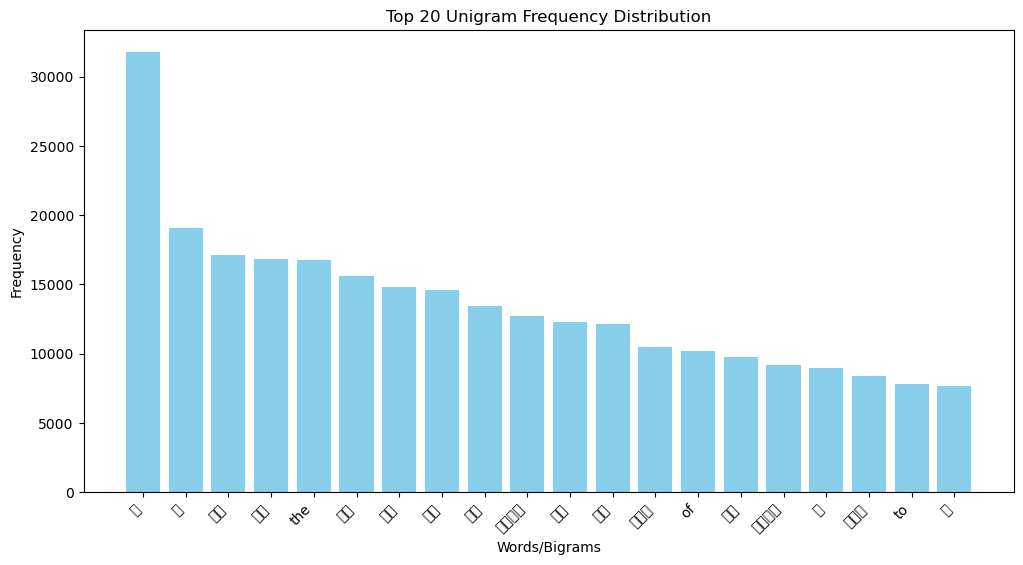

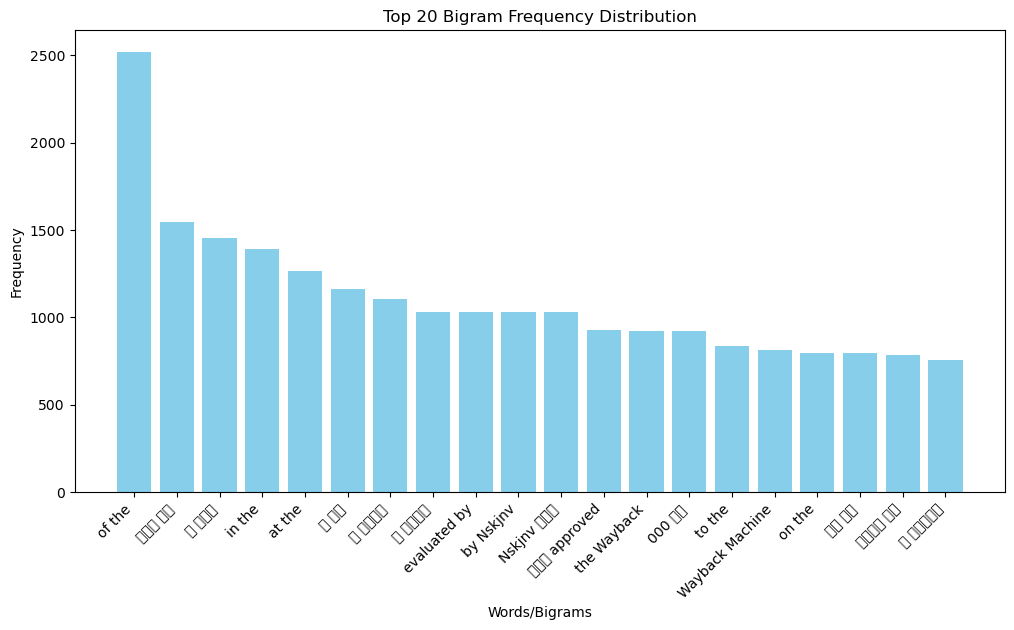

In [22]:
import os
import re
import mwparserfromhell
import matplotlib.pyplot as plt
from collections import Counter
import warnings
import sys
import os

warnings.filterwarnings("ignore") 
sys.stderr = open(os.devnull, 'w')  


input_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\cleanCorpus.txt"
unigram_output = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\wordUnigramFreq.txt"
bigram_output = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\wordBigramFreq.txt"

# Function to extract plain text from Wikipedia dump
def extract_text_from_wiki_dump(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    parsed_text = mwparserfromhell.parse(text).strip_code()
    return parsed_text

# Function to clean and tokenize text
def clean_and_tokenize(text):
    text = re.sub(r'[^\w\s]', '', text)  
    words = text.split()
    return words

# Function to count unigram and bigram frequencies
def count_ngram_frequency(words, n=1):
    ngrams = zip(*[words[i:] for i in range(n)])
    return Counter([" ".join(ngram) for ngram in ngrams])

# Function to plot frequency distribution
def plot_frequency_distribution(ngram_frequencies, title, top_n=20):
    most_common = ngram_frequencies.most_common(top_n)
    words, freqs = zip(*most_common)  
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Words/Bigrams")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Function to process Wikipedia text file and generate n-gram frequencies
def process_wikipedia_text(file_path):
    text = extract_text_from_wiki_dump(file_path)
    words = clean_and_tokenize(text)

    unigram_freq = count_ngram_frequency(words, n=1)
    bigram_freq = count_ngram_frequency(words, n=2)

    return unigram_freq, bigram_freq

# Main Execution
if __name__ == "__main__":
    if not os.path.exists(input_file):
        print(f" Error: {input_file} not found!")
        exit()

    unigram_frequencies, bigram_frequencies = process_wikipedia_text(input_file)

    # Save unigram frequencies
    with open(unigram_output, "w", encoding="utf-8") as f:
        f.write("Word\tFrequency\n")
        for word, freq in unigram_frequencies.most_common():
            f.write(f"{word}\t{freq}\n")

    # Save bigram frequencies
    with open(bigram_output, "w", encoding="utf-8") as f:
        f.write("Bigram\tFrequency\n")
        for bigram, freq in bigram_frequencies.most_common():
            f.write(f"{bigram}\t{freq}\n")

    print(f" Word unigram frequencies saved to: {unigram_output}")
    print(f" Word bigram frequencies saved to: {bigram_output}")

    # Plot unigram and bigram frequency distributions
    plot_frequency_distribution(unigram_frequencies, "Top 20 Unigram Frequency Distribution")
    plot_frequency_distribution(bigram_frequencies, "Top 20 Bigram Frequency Distribution")


In [23]:
import re
import collections
import math
from itertools import islice

# Load and tokenize corpus
def load_corpus(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read().lower()
    words = re.findall(r'[ఀ-౿]+', text)  # Extract Telugu words only
    return words

# Generate n-grams
def generate_ngrams(words, n):
    return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]

# Compute n-gram probabilities
def compute_ngram_probs(corpus, n):
    ngrams = generate_ngrams(corpus, n)
    ngram_counts = collections.Counter(ngrams)
    lower_order_counts = collections.Counter(generate_ngrams(corpus, n-1)) if n > 1 else None
    
    probs = {}
    for ngram, count in ngram_counts.items():
        prefix = ngram[:-1]  # n-1 prefix
        probs[ngram] = count / lower_order_counts[prefix] if lower_order_counts and prefix in lower_order_counts else count / len(corpus)
    
    return probs, ngram_counts

# Backoff probability calculation
def backoff_prob(word_seq, unigram_probs, bigram_probs, trigram_probs):
    if tuple(word_seq) in trigram_probs:
        return trigram_probs[tuple(word_seq)]
    elif tuple(word_seq[-2:]) in bigram_probs:
        return bigram_probs[tuple(word_seq[-2:])]
    elif tuple([word_seq[-1]]) in unigram_probs:
        return unigram_probs[tuple([word_seq[-1]])]
    else:
        return 1e-6  # Small probability for unknown words

# Morphological segmentation
def segment_word(word, unigram_probs, bigram_probs, trigram_probs):
    best_split = ""
    max_prob = 0
    for i in range(1, len(word)):
        prefix, suffix = word[:i], word[i:]
        prob = backoff_prob([prefix, suffix], unigram_probs, bigram_probs, trigram_probs)
        if prob > max_prob:
            best_split = (prefix, suffix)
            max_prob = prob
    return best_split

# Main function
def main():
    corpus_path = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\clean_corpus.txt"  # Updated path
    corpus = load_corpus(corpus_path)
    
    unigram_probs, _ = compute_ngram_probs(corpus, 1)
    bigram_probs, _ = compute_ngram_probs(corpus, 2)
    trigram_probs, _ = compute_ngram_probs(corpus, 3)
    
    # Test word segmentation
    test_word = "ఉన్నప్పుడు"  # Example Telugu word
    segmentation = segment_word(test_word, unigram_probs, bigram_probs, trigram_probs)
    print(f"Best segmentation for given test_word'{test_word}':", segmentation)

if __name__ == "__main__":
    main()


Best segmentation for given test_word'ఉన్నప్పుడు': ('ఉన్నప్పు', 'డు')


### Stop Word Removal and Stop Word List Generation
A module was developed to remove stop words from each sentence in sentence-corpus.txt. The stop word list was generated based on:

- Corpus-Based Stop Words: Words that appear in more than 5% of the sentences were identified as high-frequency words and included in the stop word list.

- Standard Telugu Stop Words: Predefined stop words from available linguistic resources like NLTK were incorporated.

- Manually Curated Stop Words: Common Telugu function words that add little meaning but frequently occur in the text were added.

In [24]:
import nltk
from nltk.corpus import stopwords
from collections import Counter


nltk.download("stopwords")

def load_corpus(file_path):
    """Load the sentence corpus from the given file path."""
    with open(file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    return [sentence.strip() for sentence in sentences]

def generate_stop_words(sentences, threshold=0.05):
    """Generate stop words list based on word frequency (top 5%)."""
    word_counts = Counter()
    total_sentences = len(sentences)
    
    for sentence in sentences:
        words = sentence.split()
        word_counts.update(set(words))  # Count unique words per sentence
    
    # Identify words appearing in more than 'threshold' % of sentences
    high_freq_words = {word for word, count in word_counts.items() if count / total_sentences > threshold}
    
    # Combine with NLTK stop words (if available for Telugu)
    telugu_stop_words = set(stopwords.words("telugu")) if "telugu" in stopwords.fileids() else set()
    custom_stop_words = {"చేత", "వలన", "గూర్చి", "కొరకు"}
    
    return telugu_stop_words | high_freq_words | custom_stop_words

def remove_stop_words(sentences, stop_words):
    """Remove stop words from each sentence."""
    cleaned_sentences = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word not in stop_words]
        cleaned_sentences.append(" ".join(filtered_words))
    return cleaned_sentences

def save_corpus(sentences, output_path):
    """Save cleaned sentences to a new file."""
    with open(output_path, "w", encoding="utf-8") as file:
        for sentence in sentences:
            file.write(sentence + "\n")

def main():
    input_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\sentence-corpus.txt"
    output_file = r"\\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\no_stop_word_corpus.txt"
    
    print("Loading corpus...")
    sentences = load_corpus(input_file)
    
    print("Generating stop words...")
    stop_words = generate_stop_words(sentences, threshold=0.05)
    
    print("Removing stop words...")
    cleaned_sentences = remove_stop_words(sentences, stop_words)
    
    print("Saving cleaned corpus...")
    save_corpus(cleaned_sentences, output_file)
    
    print("Done! Cleaned corpus saved to:", output_file)

if __name__ == "__main__":
    main()


Loading corpus...
Generating stop words...
Removing stop words...
Saving cleaned corpus...
Done! Cleaned corpus saved to: \\wsl.localhost\Ubuntu\home\paila\wikipedia_project\extracted_text\no_stop_word_corpus.txt
